In [2]:
import pandas as pd
from pandas import DataFrame, Series
import PyPDF2
from PyPDF2 import PdfFileReader
import math
import requests
import regex as re
import datetime
import matplotlib 
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import numpy as np
from datetime import datetime

In [3]:
plt.rcParams['font.size']=13

In [4]:
meeting = DataFrame(pd.read_csv("Board Committee Commission Meeting Data.csv"))
agendas = meeting['Agenda_Link']
notes = meeting['Minutes_Link']

In [6]:
for i in range(len(meeting)):
    new = re.sub(r"\s", "", meeting['Meeting_ID'][i])
    meeting['Meeting_ID'][i] = new

<ipython-input-6-77a6d85d7f34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meeting['Meeting_ID'][i] = new


In [7]:
meeting['Duration_minutes'] = meeting['Duration'] #copy a column so that I have one to replace with the cell below

In [8]:
for i in range(len(meeting['Duration'])):
    time = re.split(':',meeting['Duration'][i])
    time = [int(x) for x in time]
    seconds = time[0]*60 + time[1] + time[2]/60
    meeting.iloc[i,10] = seconds

In [10]:
dates = []
starting = []
for i in meeting['Zoom_Meeting_Start_Time']:
    unformatted = i.split()[0]
    time = i.split()[1]
    datetime = datetime.strptime(unformatted , '%m/%d/%Y')
    time_start = datetime.strptime(time , '%H:%M')
    dates.append(datetime)
    starting.append(time_start)


In [11]:
day_of_week = [x.strftime("%A") for x in dates]
day_of_week_coded = [x.strftime("%w") for x in dates]
meeting['day_of_week']=day_of_week
meeting['day_of_week_coded']=day_of_week_coded

In [13]:
meeting['starting_formatted']=[int(x.strftime("%H")) for x in starting]

In [25]:
text_dict = {}
text_list = []
for x in meeting['Meeting_ID']:
    try:
        pdfFileObject = open('pdf_agendas/'+x+'.pdf','rb')
        pdfReader = PdfFileReader(pdfFileObject)
        pageObject = pdfReader.getPage(0)
        number_of_pages = pdfReader.getNumPages()
        txt = ''
    except Exception:
        text_list.append("N/A")
        continue
    for i in range(number_of_pages):
        pageObject = pdfReader.getPage(i)
        txt+= pageObject.extractText()
    text_dict[x] = txt
    text_list.append(txt)
meeting['text']=text_list

In [26]:
text_dict = {}
text_list = []
for x in meeting['Meeting_ID']:
    try:
        pdfFileObject = open('pdf_notes/'+x+'.pdf','rb')
        pdfReader = PdfFileReader(pdfFileObject)
        pageObject = pdfReader.getPage(0)
        number_of_pages = pdfReader.getNumPages()
        txt = ''
    except Exception:
        text_list.append("N/A")
        continue
    for i in range(number_of_pages):
        pageObject = pdfReader.getPage(i)
        txt+= pageObject.extractText()
    text_dict[x] = txt
    text_list.append(txt)
meeting['note_text']=text_list

Number of Agenda Items

In [14]:
import re
import pdfminer
from subprocess import check_output
from bs4 import BeautifulSoup
from collections import defaultdict

In [15]:
def find_near(x, y):
    for x_ in range(x-5, x+5):
        for y_ in range(y-5, y+5):
            if (x_, y_) in text:
                return text[(x_, y_)]
    return None

meeting_id = meeting['Meeting_ID']
agenda_items = []
overall_list = []
for i in meeting_id:
    agenda_file = "pdf_agendas/" + i +".pdf"
    try:
        s = check_output(["pdf2txt.py", "-t", "html", "-Y", "loose", agenda_file])
    except Exception:
        agenda_items.append("N/A")
        overall_list.append("N/A")
        continue
    page = BeautifulSoup(s)

    text = {} # key=(x,y), val=text

    for div in page.find_all("div"): #gets a list of different div tags 
        style = div.attrs.get("style", "") #attrs will tell you the positioning
        m1 = re.search("left:(\d+)px", style)
        m2 = re.search("top:(\d+)px", style)
        if m1 and m2:
            x, y = int(m1.group(1)), int(m2.group(1))#each parenthesis is a different group
            text[(x,y)] = div.get_text()

    agenda_dict = {}
    rand_str = ""

    for (x,y), t in text.items():
        
        # agenda items are roughly at x=170
        if 165 < x < 175:
            # agenda numbers are rougly at x=69, same y as text
            num = find_near(69, y)
            if num and re.match('[0-9]+',num) != None:
                agenda_num = int(re.match('[0-9]+',num).group(0))
                agenda_dict[agenda_num] = t
                rand_str+=t
    agenda_items.append(agenda_dict)
    overall_list.append(rand_str)
    

In [16]:
meeting['agenda_num'] = overall_list
agenda_amount = [len(x) for x in agenda_items]
meeting['agenda_amount'] = agenda_amount

Text Analysis

In [21]:
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk import corpus
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

In [22]:
# Create a list of stop words from nltk
stop_words = set(stopwords.words("english"))

In [28]:
# Pre-process dataset to get a cleaned and normalised text corpus
corpus = []
meeting['note_text']
ds_count = len(meeting.agenda_num)
for i in range(0, ds_count):
    # Remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', str(meeting['agenda_num'][i]))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # Remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    # Convert to list from string
    text = text.split()
    
    # Stemming
    ps=PorterStemmer()
    
    # Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [29]:
# Tokenize the text and build a vocabulary of known words
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text xticklabel objects>)

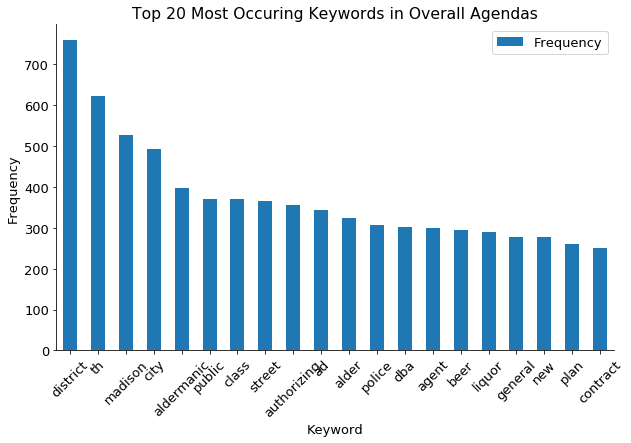

In [30]:
# View most frequently occuring keywords
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

# Convert most freq words to dataframe for plotting bar plot, save as CSV
top_words = get_top_n_words(corpus, n=20)
top_df = DataFrame(top_words)
top_df.columns=["Keyword", "Frequency"]
# print(top_df)
top_df.to_csv('_top_words.csv')

# Barplot of most freq words
# import seaborn as sns
# sns.set(rc={'figure.figsize':(13,8)})
fig, ax = plt.subplots(figsize = (10,6))
# top_df = top_df.drop([1])


top_df.plot.bar(x="Keyword",ax=ax)

ax.set_ylabel("Frequency")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Top 20 Most Occuring Keywords in Overall Agendas')
plt.xticks(rotation=45) 
# g.set_xticklabels(g.get_xticklabels(), rotation=45)
# g.figure.savefig("_keyword.png", bbox_inches = "tight")
# plt.clf()

# plt.savefig('top20keywords.EPS')

In [31]:
top_df
top_n_dict = {}
for i in range(len(top_df['Keyword'])):
#     print(top_df.iloc[i,1])
    if top_df.iloc[i,0]=='th':
        continue
    elif top_df.iloc[i,0]=='alder':
        top_n_dict['ad']+=top_df.iloc[i,1]
        continue
    elif top_df.iloc[i,0]=='liquor':
        top_n_dict['beer']+=top_df.iloc[i,1]
        continue
    elif top_df.iloc[i,0]=='contract':
        top_n_dict['plan']+=top_df.iloc[i,1]
        continue
    top_n_dict[top_df.iloc[i,0]]=top_df.iloc[i,1]
new_not_redundant_df = DataFrame({'Keyword':list(top_n_dict.keys()),'Frequency':list(top_n_dict.values())})
new_not_redundant_df=new_not_redundant_df.sort_values(by='Frequency',ascending=False)

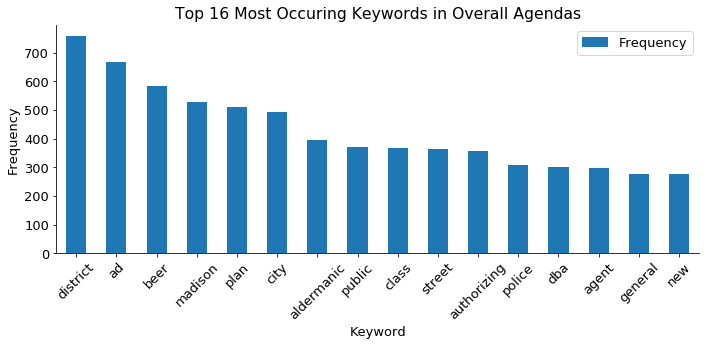

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
new_not_redundant_df.plot.bar(x="Keyword",ax=ax)
ax.set_ylabel("Frequency")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Top '+ str(len(new_not_redundant_df)) +' Most Occuring Keywords in Overall Agendas')
plt.xticks(rotation=45) 
plt.tight_layout()

plt.savefig('top16keywords.pdf', bbox='tight')

In [35]:
important_keys = list(new_not_redundant_df['Keyword'])
important_keys[1]='alder'
important_keys[2]='liquor'
new_not_redundant_df['New_Keywords']=important_keys

In [36]:
new_not_redundant_df

,Keyword,Frequency,New_Keywords
0,district,759,district
8,ad,667,alder
12,beer,583,liquor
1,madison,527,madison
15,plan,511,plan
2,city,492,city
3,aldermanic,396,aldermanic
4,public,370,public
5,class,369,class
6,street,365,street


Adding Committee

In [1]:
committee = ['Common Council Executive Committee',
 'Common Council Executive Committee',
 'Finance Committee',
 'Common Council Executive Committee',
 'Plan Commission',
 'Transportation Commission',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Alcohol License Review Committee',
 'Plan Commission',
 'Finance Committee',
 'Urban Design Commission',
 'Landmarks Commission',
 'MATPB',
 'Common Council Executive Committee',
 'Food Policy Council',
 'MATPB',
 'Plan Commission',
 'Finance Committee',
 'Transportation Commission',
 'Board of Park Commissioners',
 'Monona Terrace Community & Convention Center Board',
 'Common Council Executive Committee',
 'Plan Commission',
 'Task Force on Golf in Madison Parks',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Alcohol License Review Committee',
 'Zoning Board of Appeals',
 'Common Council Executive Committee',
 'Urban Design Commission',
 'Alcohol License Review Committee',
 'Alcohol License Review Committee',
 'Room Tax Commission',
 'Landmarks Commission',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Madison Food Policy Council',
 'Community Development Block Grant Committee',
 'Madison Public Library Board',
 'Plan Commission',
 'Equal Opportunities Commission',
 'Complete Count Committee',
 'Finance Committee',
 'Public Safety Review Committee',
 'Board of Park Commissioners',
 "President's Work Group on Council Communication Tools & Processes",
 'CDA Board',
 'Equal Opportunities Commission',
 'Common Council Executive Committee',
 'Transportation Policy and Planning Board',
 'Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Economic Development Committee',
 'Alcohol License Review Committee',
 'MATPB',
 'Monona Terrace Community & Convention Center Board',
 'Monona Terrace Community & Convention Center Board',
 'PSRC',
 'Finance Committee',
 'PSRC',
 'Sustainable Madison Committee',
 'Water Utility Board',
 'MATPB',
 'Transportation Commission',
 'Community Services Committee',
 'Housing Strategy Committee',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Common Council Executive Committee',
 'Monona Terrace Community & Convention Center Board',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Plan Commission',
 'Equal Opportunities Commission',
 'Task Force on Golf in Madison Parks',
 'Monona Terrace Community & Convention Center Board',
 'Madison Food Policy Council',
 'Downtown Coordinating Committee',
 'Landlord and Tenant Issues Committee',
 'Madison Food Policy Council',
 'Urban Design Commission',
 'MATPB',
 'PSRC',
 'Body-Worn Camera Feasibility Review Committee',
 'Madison Public Library Board',
 'Affirmative Action Commission',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals',
 'Transportation Policy and Planning Board',
 'PSRC',
 'Room Tax Commission',
 'Madison Food Policy Council',
 'Madison Arts Commission',
 'Board of Public Works',
 'Public Safety Review Committee',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Madison Food Policy Council',
 'Board of Park Commissioners',
 "President's Work Group on Council Communication Tools & Processes",
 'Community Development Authority Board',
 'Madison Public Library Board',
 'Equal Opportunities Commission',
 'Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Traffic Calming Subcommittee',
 'Landmarks Commission',
 'Plan Commission',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'City-Wide Violence Meeting',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'PSRC',
 'Transportation Policy and Planning Board',
 'Alcohol License Review Committee',
 'Task Force on Golf in Madison Parks',
 'PSRC',
 "President's Work Group on Council Communication Tools & Processes",
 'Monona Terrace Community & Convention Center Board',
 'Monona Terrace Community & Convention Center Board',
 'CDBG Committee',
 'Traffic Calming Subcommittee',
 'Body-Worn Camera Feasibility Review Committee',
 'Finance Committee',
 'Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Personnel Board',
 'Board of Public Works',
 'Transportation Commission',
 "President's Work Group on Council Communication Tools & Processes",
 'Madison Food Policy Council',
 'Housing Strategy Committee',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Task Force on Golf in Madison Parks',
 'Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Finance Committee',
 'Sustainable Madison Committee',
 'Plan Commission',
 'Water Utility Board',
 'Public Safety Review Committee',
 'Food Systems Recovery and Resilience Work Group',
 'Urban Design Commission',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'MLK Commission',
 'Public Safety Review Committee',
 'Plan Commission',
 'Body-Worn Camera Feasibility Review Committee',
 'Task Force on Golf in Madison Parks',
 'Deferred Compensation Committee']

In [38]:
meeting['Committee']=committee

X_DF

In [44]:
X_df = meeting[['agenda_amount','Duration_minutes','day_of_week_coded']].copy().copy()
time_block = []
for x in meeting['starting_formatted']:
    if 9<=x<=17:
        time_block.append(2)
    elif x >17:
        time_block.append(3)
    else:
        time_block.append(1)
X_df['starting_formatted']=time_block

Adding Committee

In [3]:
unique_committee = list(set(committee))
unique_committee

['City-Wide Violence Meeting',
 'Water Utility Board',
 'Complete Count Committee',
 'Madison Public Library Board',
 'Downtown Coordinating Committee',
 'Madison Food Policy Council',
 'Room Tax Commission',
 'Landlord and Tenant Issues Committee',
 'Personnel Board',
 'CDA Board',
 'Traffic Calming Subcommittee',
 'Affirmative Action Commission',
 'Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group',
 'Community Development Authority Board',
 'CDBG Committee',
 'Board of Public Works',
 'Board of Park Commissioners',
 'PSRC',
 'Alcohol License Review Committee',
 'Body-Worn Camera Feasibility Review Committee',
 'Finance Committee',
 'Community Services Committee',
 'MATPB',
 'Plan Commission',
 'Zoning Board of Appeals',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Landmarks Commission',
 'Public Safety Review Committee',
 "President's Work Group on Council Communication To

In [47]:
for i in unique_committee:
    tracker = []
    for x in meeting['Committee']:
        if x==i:
            tracker.append(1)
        else:
            tracker.append(0)
    X_df[i]=tracker

Adding Top Words

In [53]:
for top_word in new_not_redundant_df['New_Keywords']:
    word_count=[]
    for text in meeting['note_text']:
        if top_word in text.lower().split():
            word_count.append(1)
        else:
            word_count.append(0)
    X_df[top_word]=word_count

**Lasso**

In [57]:
from sklearn import linear_model

In [202]:
clf = linear_model.Lasso(alpha=0.1)

In [203]:
clf.fit(X_df, meeting['Participants'])

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [204]:
agenda_numbers=10
Duration_minutes=50
day_of_week_coded=5
starting_coded=3
district =0
alder=0
liquor=0
madison =0
plan = 0
city= 0
aldermanic = 0
public = 0
class_=0 
street = 0
authorizing = 0
police = 0
dba =0
agent = 0
general =0
new = 0
cam =0# Body-Worn Camera Feasibility Review Committee
CDBG =0# CDBG Committee
PSRC=0# PSRC
WUB=0# Water Utility Board
DCC=0# Deferred Compensation Committee
MAC=0# Madison Arts Commission
FPC=0# Food Policy Council
EOC=0# Equal Opportunities Commission
PB=0# Personnel Board
LC=0# Landmarks Commission
PC=0# Plan Commission
violence=0# City-Wide Violence Meeting
alc =0# Alcohol License Review Committee
safety=0# Public Safety Review Committee
count=0# Complete Count Committee
CCEC=0# Common Council Executive Committee
task_park=0# Task Force on Golf in Madison Parks
MLK=0# MLK Commission
UDC=0# Urban Design Commission
TCS=0# Traffic Calming Subcommittee
BPC=0# Board of Park Commissioners
TC=0# Transportation Commission
HSC=0# Housing Strategy Committee
alder=0# Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight
SMC=0# Sustainable Madison Committee
CDAB=0# Community Development Authority Board
finance=0# Finance Committee
ad_hoc=0# Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group
grant=0# Community Development Block Grant Committee
BPW=0# Board of Public Works
zone=0# Zoning Board of Appeals
food_recovery=0# Food Systems Recovery and Resilience Work Group
code=0# Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals
tools=0# President's Work Group on Council Communication Tools & Processes
landlord=0# Landlord and Tenant Issues Committee
food_policy=0# Madison Food Policy Council
transport=0# Transportation Policy and Planning Board
CDA=0# CDA Board
MATPB=0# MATPB
library=0# Madison Public Library Board
terrace=0# Monona Terrace Community & Convention Center Board
downtown=0# Downtown Coordinating Committee
AAC=0# Affirmative Action Commission
tax=0# Room Tax Commission
CSC=0# Community Services Committee
econ=0# Economic Development Committee

predicted = clf.predict([[agenda_numbers,Duration_minutes,day_of_week_coded,starting_coded,district,alder, liquor, madison, plan, city, aldermanic, public, class_, street, authorizing, police, dba, agent, general, new,cam,CDBG,PSRC,WUB,DCC,MAC,FPC,EOC,PB,LC,PC,violence,alc,safety,count,CCEC,task_park,MLK,UDC,TCS,BPC,TC,HSC,alder,SMC,CDAB,finance,ad_hoc,grant,BPW,zone,food_recovery,code,tools,landlord,food_policy,transport,CDA,MATPB,library,terrace,downtown,AAC,tax,CSC,econ]])
                          

print('(Model with Committee) The number of Partipants will be around {} people \n'.format(predicted))

print("Keywords from agenda_num applied on agenda_num")


def formula(reg, columns):
    rv = ""
    for i in range(len(columns)):
        rv += "{}*({}) + \n".format(reg.coef_[i], columns[i])
    rv += str(reg.intercept_)
    return rv

print("Number of Participants ~= " + formula(clf, list(X_df.columns)))





(Model with Committee) The number of Partipants will be around [19.91151535] people 

Keywords from agenda_num applied on agenda_num
Number of Participants ~= 0.25492617853919547*(agenda_amount) + 
0.340572457293434*(Duration_minutes) + 
-0.07981776164935768*(day_of_week_coded) + 
15.149895999930592*(starting_formatted) + 
-15.09487782597179*(CDBG Committee) + 
-22.453500045983063*(Body-Worn Camera Feasibility Review Committee) + 
0.0*(CDA Board) + 
-0.0*(Community Development Block Grant Committee) + 
1.764596010552123*(Economic Development Committee) + 
10.575992202876243*(Personnel Board) + 
0.0*(Food Systems Recovery and Resilience Work Group) + 
-0.0*(Landlord and Tenant Issues Committee) + 
24.331988102360512*(Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals) + 
-4.762454754848627*(MATPB) + 
0.0*(Equal Opportunities Commission) + 
0.0*(Community Services Committee) + 
-13.442731912936978*(Board of Park Commissioners) + 
0.0*(Traffic Calming Subcommittee) +

**Plotting With Every Coefficient**

In [205]:
coef_df_committee = DataFrame({'Column':list(X_df.columns), 'Coefficients':list(clf.coef_)})
committee_coef = coef_df_committee[20:]
committee_coef

,Column,Coefficients
20,Transportation Policy and Planning Board,-28.024150
21,Community Development Authority Board,3.807273
22,Downtown Coordinating Committee,-16.033578
23,Landmarks Commission,-23.962103
24,Madison Arts Commission,0.000000
25,Ad Hoc Task Force on the Structure of City Gov...,0.000000
26,Urban Design Commission,4.822309
27,City-Wide Violence Meeting,0.000000
28,Food Policy Council,0.000000
29,Finance Committee,-0.000000


Text(0.5, 1.0, 'Impact on Predicted Participants by Committee (based on model)')

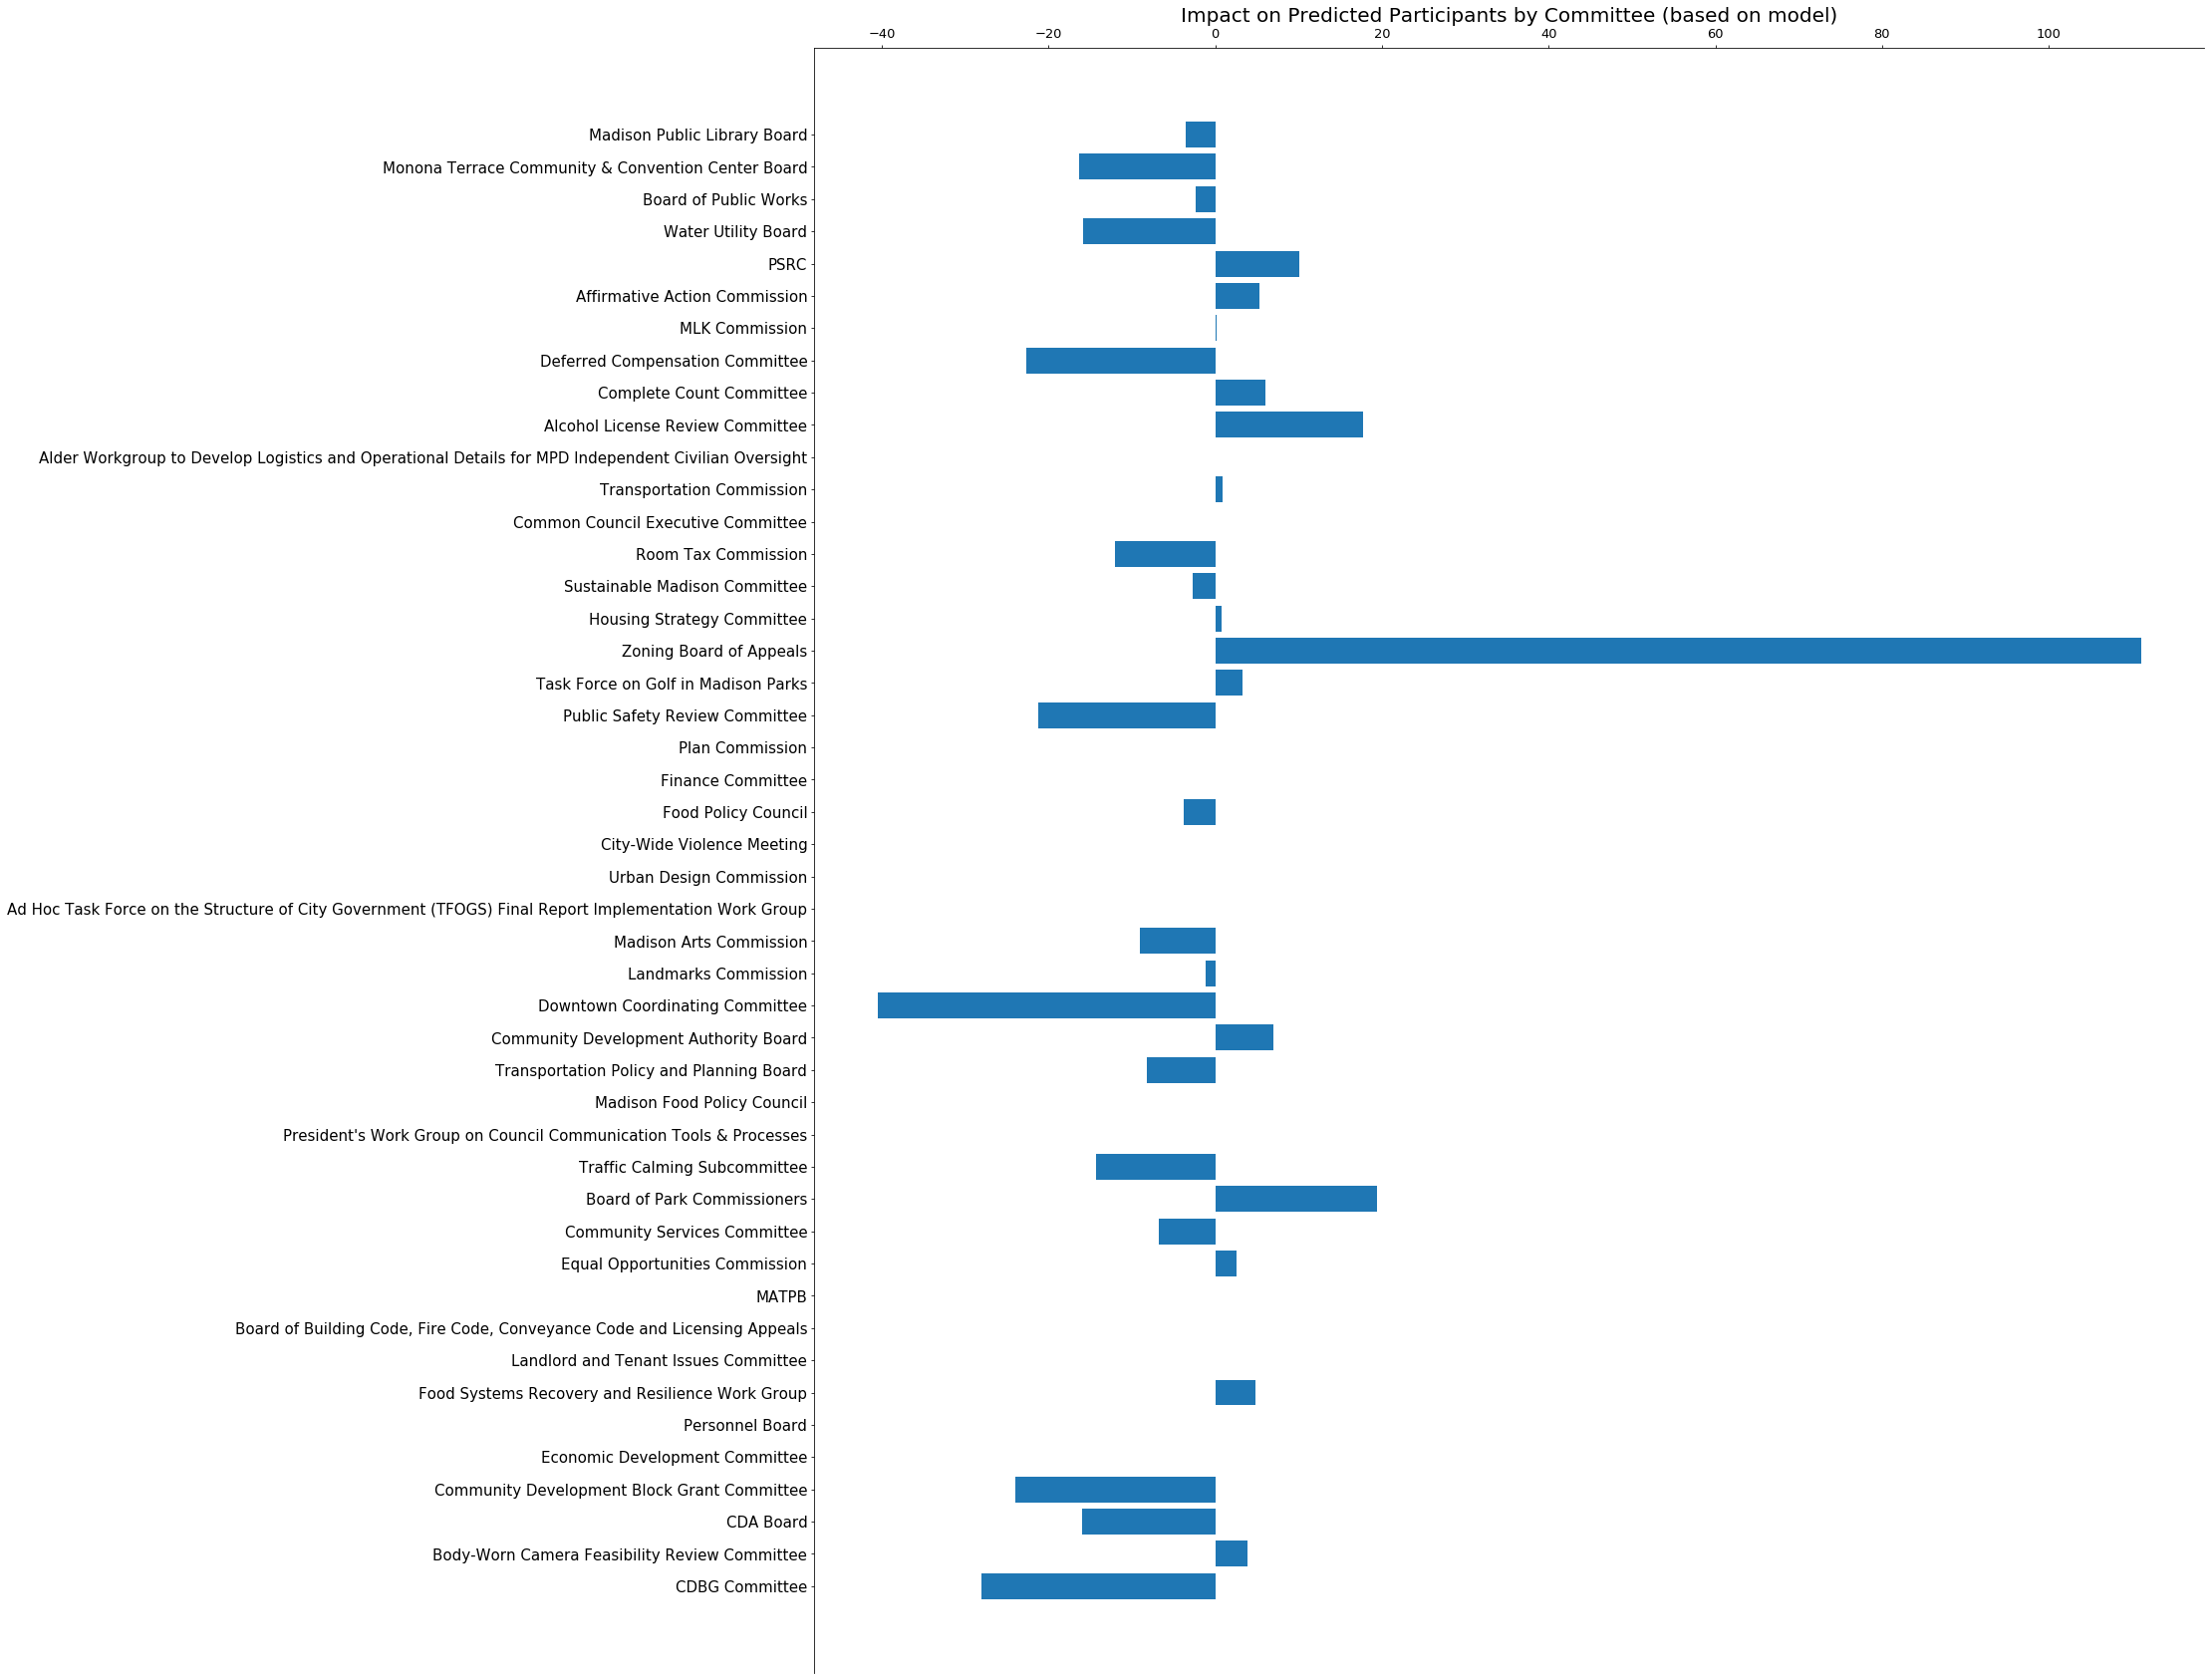

In [206]:
fig,ax=plt.subplots(figsize=(25,30))

plt.barh(y=unique_committee, width = committee_coef['Coefficients'])
plt.xticks(rotation=90) 
# plt.tight_layout()
plt.xticks(size = 15)
plt.yticks(size = 15)
ax.xaxis.tick_top()
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_title('Impact on Predicted Participants by Committee (based on model)',size=20)
# plt.savefig('commmittee_coef.png',bbox_inches = "tight")

**Plotting with Coefficients not zero**

In [207]:
import math

In [234]:
coef_not_zero = coef_df_committee[abs(coef_df_committee['Coefficients'])>0.5]
coef_not_zero=coef_not_zero.sort_values(by="Coefficients",ascending=True)

In [242]:
coef_not_zero.describe()

,Coefficients
count,41.000000
mean,-1.456474
std,22.693258
min,-40.531131
25%,-14.318618
50%,-2.690173
75%,5.311111
max,111.087225


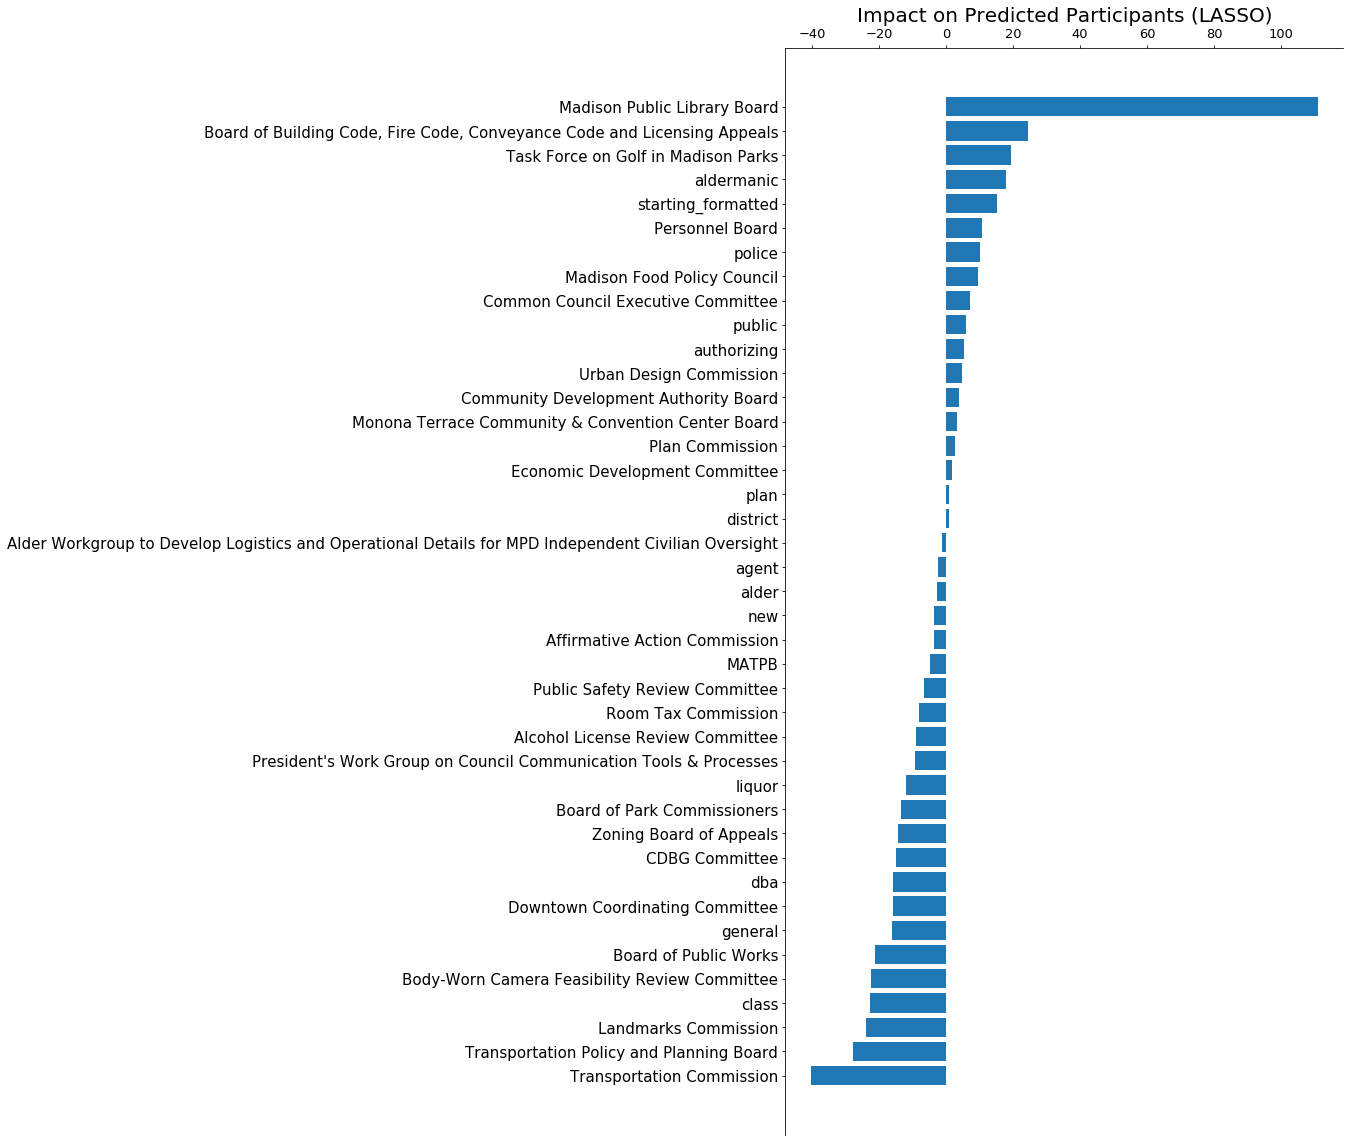

In [237]:
fig,ax=plt.subplots(figsize=(10,20))

plt.barh(y=coef_not_zero['Column'], width = coef_not_zero['Coefficients'])
plt.xticks(rotation=90) 
# plt.tight_layout()
plt.xticks(size = 15)
plt.yticks(size = 15)
ax.xaxis.tick_top()
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_title('Impact on Predicted Participants (LASSO)',size=20)
plt.savefig('lasso_coef.png',bbox_inches = "tight")

Testing (With Keywords)

In [210]:
from sklearn.model_selection import train_test_split

In [214]:
test_df = X_df.copy().copy()
test_df['Participants']=meeting['Participants']
train, test = train_test_split(test_df)
clf = linear_model.LinearRegression()
clf.fit(train.loc[:, train.columns != 'Participants'], train["Participants"])
print("Training Score: ",clf.score(train.loc[:, train.columns != 'Participants'], train["Participants"]),"\n"
 "Testing Score: ", clf.score(test.loc[:, test.columns != 'Participants'], test["Participants"]))





Training Score:  0.8238209238692813 
Testing Score:  0.6274345697768811


Testing Function for different alpha

In [249]:
def testing_alpha(data,a):
    test_df = data.copy().copy()
    test_df['Participants']=meeting['Participants']
    train, test = train_test_split(test_df)
    model = linear_model.Lasso(alpha=a)
    model.fit(train.loc[:, train.columns != 'Participants'], train["Participants"])
#     print("Training Score: ",clf.score(train.loc[:, train.columns != 'Participants'], train["Participants"]),"\n"
#      "Testing Score: ", clf.score(test.loc[:, test.columns != 'Participants'], test["Participants"]))
    return model.score(test.loc[:, test.columns != 'Participants'], test["Participants"])

In [250]:
for i in [.001,.01,.1,1,1.5,2]:
    print('alpha:', i ,',score:' ,testing_alpha(X_df,i))

alpha: 0.001 ,score: 0.5590827161151066
alpha: 0.01 ,score: 0.5510716219822852
alpha: 0.1 ,score: 0.638018894659564
alpha: 1 ,score: 0.6154538681703434
alpha: 1.5 ,score: 0.5806652244490608
alpha: 2 ,score: -0.07704337539971462


**LASSO without Keywords**

In [217]:
X_lasso = meeting[['agenda_amount','Duration_minutes','day_of_week_coded']].copy().copy()
time_block = []
for x in meeting['starting_formatted']:
    if 9<=x<=17:
        time_block.append(2)
    elif x >17:
        time_block.append(3)
    else:
        time_block.append(1)
X_lasso['starting_formatted']=time_block
for i in unique_committee:
    tracker = []
    for x in meeting['Committee']:
        if x==i:
            tracker.append(1)
        else:
            tracker.append(0)
    X_lasso[i]=tracker

In [218]:
lasso_v2 = linear_model.Lasso(alpha=0.1)
lasso_v2.fit(X_lasso, meeting['Participants'])

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [219]:
agenda_numbers=10
Duration_minutes=50
day_of_week_coded=5
starting_coded=3
cam =0# Body-Worn Camera Feasibility Review Committee
CDBG =0# CDBG Committee
PSRC=0# PSRC
WUB=0# Water Utility Board
DCC=0# Deferred Compensation Committee
MAC=0# Madison Arts Commission
FPC=0# Food Policy Council
EOC=0# Equal Opportunities Commission
PB=0# Personnel Board
LC=0# Landmarks Commission
PC=0# Plan Commission
violence=0# City-Wide Violence Meeting
alc =0# Alcohol License Review Committee
safety=0# Public Safety Review Committee
count=0# Complete Count Committee
CCEC=0# Common Council Executive Committee
task_park=0# Task Force on Golf in Madison Parks
MLK=0# MLK Commission
UDC=0# Urban Design Commission
TCS=0# Traffic Calming Subcommittee
BPC=0# Board of Park Commissioners
TC=0# Transportation Commission
HSC=0# Housing Strategy Committee
alder=0# Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight
SMC=0# Sustainable Madison Committee
CDAB=0# Community Development Authority Board
finance=0# Finance Committee
ad_hoc=0# Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group
grant=0# Community Development Block Grant Committee
BPW=0# Board of Public Works
zone=0# Zoning Board of Appeals
food_recovery=0# Food Systems Recovery and Resilience Work Group
code=0# Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals
tools=0# President's Work Group on Council Communication Tools & Processes
landlord=0# Landlord and Tenant Issues Committee
food_policy=0# Madison Food Policy Council
transport=0# Transportation Policy and Planning Board
CDA=0# CDA Board
MATPB=0# MATPB
library=0# Madison Public Library Board
terrace=0# Monona Terrace Community & Convention Center Board
downtown=0# Downtown Coordinating Committee
AAC=0# Affirmative Action Commission
tax=0# Room Tax Commission
CSC=0# Community Services Committee
econ=0# Economic Development Committee

predicted = lasso_v2.predict([[agenda_numbers,Duration_minutes,day_of_week_coded,starting_coded,cam,CDBG,PSRC,WUB,DCC,MAC,FPC,EOC,PB,LC,PC,violence,alc,safety,count,CCEC,task_park,MLK,UDC,TCS,BPC,TC,HSC,alder,SMC,CDAB,finance,ad_hoc,grant,BPW,zone,food_recovery,code,tools,landlord,food_policy,transport,CDA,MATPB,library,terrace,downtown,AAC,tax,CSC,econ]])
                          

print('(Model with Committee) The number of Partipants will be around {} people \n'.format(predicted))

print("Keywords from agenda_num applied on agenda_num")


def formula(reg, columns):
    rv = ""
    for i in range(len(columns)):
        rv += "{}*({}) + \n".format(reg.coef_[i], columns[i])
    rv += str(reg.intercept_)
    return rv

print("Number of Participants ~= " + formula(lasso_v2, list(X_lasso.columns)))






(Model with Committee) The number of Partipants will be around [15.85296209] people 

Keywords from agenda_num applied on agenda_num
Number of Participants ~= 0.07649339866765435*(agenda_amount) + 
0.3759767577852575*(Duration_minutes) + 
-0.5493122445315701*(day_of_week_coded) + 
16.27276821291252*(starting_formatted) + 
-7.272829166956871*(CDBG Committee) + 
-9.085566754645361*(Body-Worn Camera Feasibility Review Committee) + 
15.420814940670788*(CDA Board) + 
0.0*(Community Development Block Grant Committee) + 
-0.0*(Economic Development Committee) + 
26.757838100553133*(Personnel Board) + 
0.0*(Food Systems Recovery and Resilience Work Group) + 
-0.0*(Landlord and Tenant Issues Committee) + 
24.47942202516171*(Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals) + 
-9.58936206993535*(MATPB) + 
0.0*(Equal Opportunities Commission) + 
-0.0*(Community Services Committee) + 
-14.720069772349776*(Board of Park Commissioners) + 
0.0*(Traffic Calming Subcommittee) + 


In [220]:
coef_no_word = DataFrame({'Column':list(X_lasso.columns), 'Coefficients':list(lasso_v2.coef_)})
coef_no_word[abs(coef_no_word['Coefficients'])>.05]

,Column,Coefficients
0,agenda_amount,0.076493
1,Duration_minutes,0.375977
2,day_of_week_coded,-0.549312
3,starting_formatted,16.272768
4,CDBG Committee,-7.272829
5,Body-Worn Camera Feasibility Review Committee,-9.085567
6,CDA Board,15.420815
9,Personnel Board,26.757838
12,"Board of Building Code, Fire Code, Conveyance ...",24.479422
13,MATPB,-9.589362


Testing

In [225]:
from sklearn.model_selection import train_test_split
test_df = X_lasso.copy().copy()
test_df['Participants']=meeting['Participants']
train, test = train_test_split(test_df)
lasso_v2 = linear_model.LinearRegression()
lasso_v2.fit(train.loc[:, train.columns != 'Participants'], train["Participants"])
print("Training Score: ",lasso_v2.score(train.loc[:, train.columns != 'Participants'], train["Participants"]),"\n"
 "Testing Score: ", lasso_v2.score(test.loc[:, test.columns != 'Participants'], test["Participants"]))




Training Score:  0.7884645221761859 
Testing Score:  -1.013847692111395e+19


In [251]:
for i in [.001,.01,.1,1,1.5,2]:
    print('alpha:', i ,',score:' ,testing_alpha(X_lasso,i))

alpha: 0.001 ,score: 0.42617468834447525
alpha: 0.01 ,score: 0.018674649510443175
alpha: 0.1 ,score: -0.3236943469298965
alpha: 1 ,score: 0.40315282921133
alpha: 1.5 ,score: 0.6846785035477764
alpha: 2 ,score: 0.4187262694651544
